## Bayesian Statistics Project - 3A ENSAE 

#### Dating and Forecasting Turning Points by Bayesian Clustering with Dynamic Structure

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.signal import detrend
from tslearn.clustering import TimeSeriesKMeans
from changepoint_detection import *
from sklearn.metrics import normalized_mutual_info_score

In [5]:
with open("colomns_out.json", "r") as json_file:
    out_cols = json.load(json_file)["out_cols"]

In [6]:
df = pd.read_csv('dataset_treated.csv')
df = df.dropna()
df = df.drop(columns=out_cols)
dataset = to_time_series_dataset(df.drop(columns=['Date']).values.T)

In [7]:
dataset.shape

(74, 64, 1)

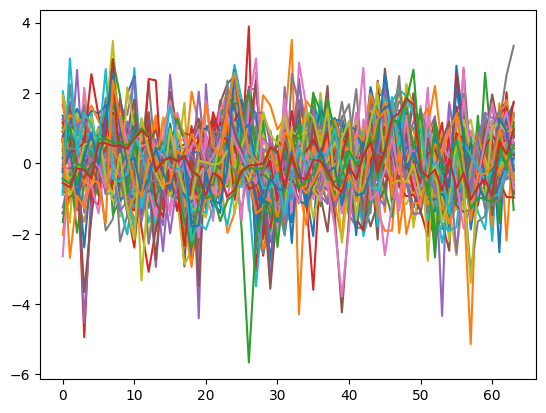

In [8]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
dataset = scaler.fit_transform(dataset)
dataset = detrend(dataset, axis=1)

for i in range(len(dataset)):
    plt.plot(dataset[i].ravel())

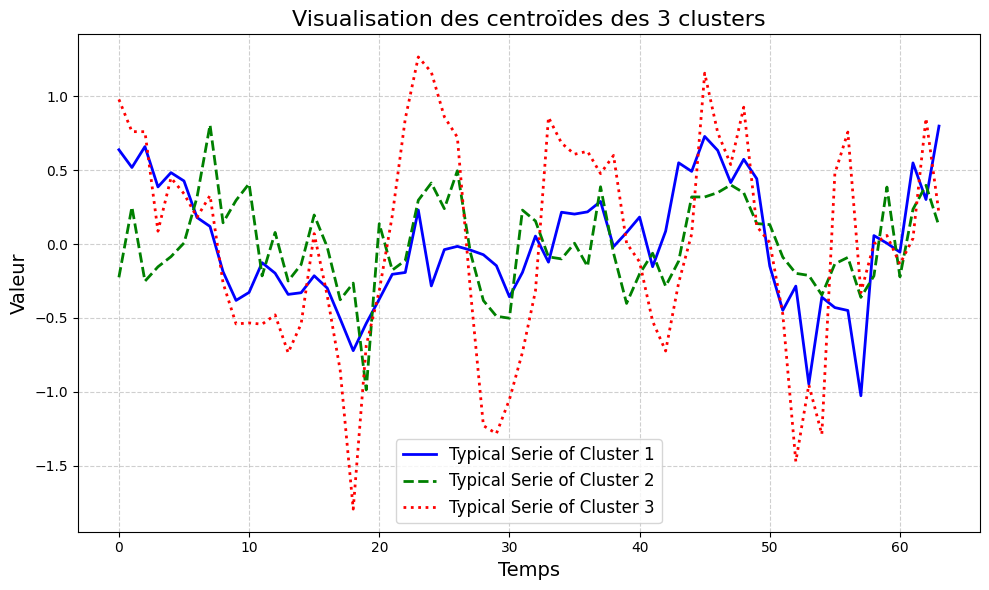

In [9]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
labels = model.fit_predict(dataset)

typical_TS0 = np.mean(dataset[labels == 0], axis=0)
typical_TS1 = np.mean(dataset[labels == 1], axis=0)
typical_TS2 = np.mean(dataset[labels == 2], axis=0)

plt.figure(figsize=(10, 6))  
plt.plot(typical_TS0.ravel(), label="Typical Serie of Cluster 1", color="blue", linestyle="-", linewidth=2)
plt.plot(typical_TS1.ravel(), label="Typical Serie of Cluster 2", color="green", linestyle="--", linewidth=2)
plt.plot(typical_TS2.ravel(), label="Typical Serie of Cluster 3", color="red", linestyle=":", linewidth=2)

plt.title("Visualisation des centroïdes des 3 clusters", fontsize=16)
plt.xlabel("Temps", fontsize=14)
plt.ylabel("Valeur", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [10]:
dataset.shape

(74, 64, 1)

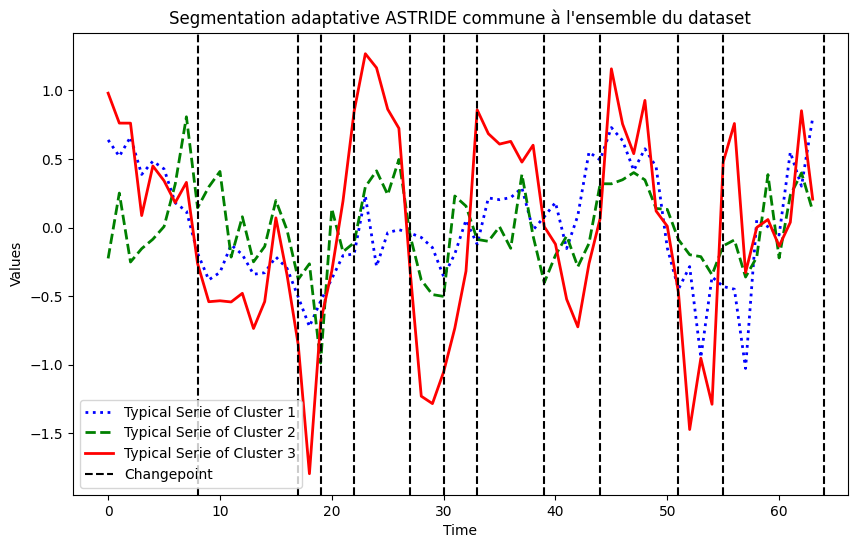

In [11]:
astride = ASTRIDE_transf(np.array(dataset[labels==2].reshape((dataset[labels==2].shape[:2]))), 12, 5, [])
astride.mts_bkps_

plt.figure(figsize=(10, 6))

plt.plot(typical_TS0.ravel(), label="Typical Serie of Cluster 1", color="blue", linestyle=":", linewidth=2)
plt.plot(typical_TS1.ravel(), label="Typical Serie of Cluster 2", color="green", linestyle="--", linewidth=2)
plt.plot(typical_TS2.ravel(), label="Typical Serie of Cluster 3", color="red", linestyle="-", linewidth=2)

for cp in astride.mts_bkps_:
    plt.axvline(x=cp, color='black', linestyle='--', label='Changepoint' if 'Changepoint' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.title("Segmentation adaptative ASTRIDE commune à l'ensemble du dataset")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [12]:
df_res = pd.DataFrame({
    'serie': df.columns[1:],
    'label': labels
})

with open("./src/res_kaufmann.json", "r") as file:
    kaufmann_res = json.load(file)

data = [(serie, label) for label, series in kaufmann_res.items() for serie in series]

df_kauf = pd.DataFrame(data, columns=["serie", "label_kauf"])

df_kauf["label_kauf"] = df_kauf["label_kauf"].astype(str)

results = pd.merge(df_res, df_kauf, on="serie", how="left")

In [13]:
labels_1 = results.label.to_list()
labels_2 = results.label_kauf.to_list()

normalized_mutual_info_score(labels_1, labels_2)

0.206486575307669